In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/Masterarbeit')
import numpy as np
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.dataloading import MultiThreadedAugmenter, SingleThreadedAugmenter
from batchgenerators.transforms import Compose
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2, SpatialTransform, MirrorTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, GammaTransform, ContrastAugmentationTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform, RicianNoiseTransform
from batchgenerators.augmentations.crop_and_pad_augmentations import crop
import pandas as pd
import random
from time import time
import matplotlib.pyplot as plt
import utils_vis

In [2]:
csv_path = '/home/kevinteng/Desktop/csv_npy/three_classes_npy.csv'


def get_split_fold(data, val_fold=0, test_fold=-1):
    """
    If the data set is already split according to folds with indices [-1, 0, 1, 2, 3]
    @param data: csv file where the data sets are stored
    @param val_fold: validation fold to be popped
    @param test_fold: test fold to be popped
    @return: dictionaries of train, val, train dictionary
    """
    # return indices of fold data
    test_idx = np.where(data['fold']==test_fold)[0]
    val_idx = np.where(data['fold']==val_fold)[0]
    train_idx = np.where((data['fold'] != -1) & (data['fold'] != 0))[0]

    # create dictionary for each data set
    train_ds = {'npy_path':[data['npy_path'].tolist()[i] for i in train_idx],
                'labels':[data['labels'].tolist()[i] for i in train_idx],
                'patient_id':[data['patient_id'].tolist()[i] for i in train_idx]}
    val_ds = {'npy_path':[data['npy_path'].tolist()[i] for i in val_idx],
                'labels':[data['labels'].tolist()[i] for i in val_idx],
                'patient_id':[data['patient_id'].tolist()[i] for i in val_idx]}
    test_ds = {'npy_path':[data['npy_path'].tolist()[i] for i in test_idx],
                'labels':[data['labels'].tolist()[i] for i in test_idx],
                'patient_id':[data['patient_id'].tolist()[i] for i in test_idx]}

    return {'train_ds':train_ds, 'val_ds': val_ds, 'test_ds':test_ds}


class DataLoader3D(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded, crop=True, seed_for_shuffle=1234,
                 return_incomplete=False, shuffle=True, infinite=True):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the retured batch will have
        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        # original patch size with [slices, width, height]
        self.patch_size = patch_size
        self.num_modalities = 3
        self.indices = list(range(len(data['labels'])))
        self.crop = crop

    @staticmethod
    def load_patient(img_path):
        img = np.load(img_path, mmap_mode="r")
        return img

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        patients_for_batch = [self._data['npy_path'][i] for i in idx]
        patients_labels = [self._data['labels'][i] for i in idx]
        patient_id = [self._data['patient_id'][i] for i in idx]
        # initialize empty array for data and seg
        img = np.zeros((self.batch_size, self.num_modalities, *self.patch_size), dtype=np.float32)

        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(patients_for_batch):
            patient_data = self.load_patient(j)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            # swap axes for crop function, (z, x, y, m) => (m, x, y, z)
            patient_data = np.swapaxes(patient_data,0,-1)
            if crop:
                patient_data = crop(patient_data[None], seg=None, crop_size=self.patch_size, crop_type="center")
            img[i] = patient_data[0]
        # img = np.swapaxes(img, 1, -1)
        patients_labels = np.array(patients_labels)
        return {'data': img, 'lbl': patients_labels, 'patient_id': patient_id}


class BalancedDataLoader3D(DataLoader):
    def __init__(self, data, sample_size, sample_per_class, patch_size, num_threads_in_multithreaded, crop=True, seed_for_shuffle=1234,
                 return_incomplete=False, shuffle=True, infinite=True):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the retured batch will have
        """
        super().__init__(data, sample_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        assert sample_size<=len(data['labels']), "Sample size should be less than data set size!"
        self.patch_size = patch_size
        self.num_modalities = 3
        self.indices = list(range(len(data['labels'])))
        self.crop = crop
        self.sample_per_class = sample_per_class
        self.n_class = np.unique(self._data['labels'])

    @staticmethod
    def load_patient(img_path):
        img = np.load(img_path, mmap_mode="r")
        return img
      # need to fix!
    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        balanced_class_indx = []
        for c in self.n_class:
            class_sample = 0
            while class_sample<=self.sample_per_class:
                idx = self.get_indices()
                # retrieve the patients label
                patients_labels = [self._data['labels'][i] for i in idx]
                # evaluate the position of the patients where the label match the class
                class_indx = np.where(np.array(patients_labels)==c)[0]
                # map back to the indices of the patient labels where it match
                class2labels = [idx[j] for j in class_indx]
                # check if the length match
                class_sample = len(class2labels)
                if class_sample>self.sample_per_class:
                    class2labels = np.random.choice(class2labels, self.sample_per_class, replace=False).tolist()
            balanced_class_indx.append(class2labels)
        # flatten list of list
        bci = sum(balanced_class_indx, [])
        # shuffle the list
        random.shuffle(bci)
        balanced_patients_labels = [self._data['labels'][i] for i in bci]
        balanced_patients_for_batch = [self._data['npy_path'][i] for i in bci]
        balanced_patient_id = [self._data['patient_id'][i] for i in bci]
        # initialize empty array for data and seg
        img = np.zeros((self.sample_per_class*len(self.n_class), self.num_modalities, *self.patch_size), dtype=np.float32)
        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(balanced_patients_for_batch):
            patient_data = self.load_patient(j)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            # swap axes for crop function, (z, x, y, m) => (m, x, y, z)
            patient_data = np.swapaxes(patient_data,0,-1)
            if crop:
                patient_data = crop(patient_data[None], seg=None, crop_size=self.patch_size, crop_type="center")
            img[i] = patient_data[0]
        # img = np.swapaxes(img, 1, -1)
        patients_labels = np.array(balanced_patients_labels)
        return {'data': img, 'lbl': patients_labels, 'patient_id': balanced_patient_id}

    
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform(
            patch_size,
            [i // 2 for i in patch_size],
            do_elastic_deform=True,
            alpha=(0., 300.),
            sigma=(20., 40.),
            do_rotation=True,
            angle_x=(0.,0.),
            angle_y=(0.,0.),
            angle_z=(-np.pi/15., np.pi/15.),
            do_scale=True,
            scale=(1/1.15, 1.15),
            random_crop=False,
            border_mode_data='constant',
            border_cval_data=0,
            order_data=3,
            p_el_per_sample=0.5, p_rot_per_sample=0.5, p_scale_per_sample=0.5
        )
    )

    # now we mirror along the y-axis 
    tr_transforms.append(MirrorTransform(axes=(1,)))

    # brightness transform for 15% of samples
    tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.5))

    # gamma transform. This is a nonlinear transformation of intensity values
    # (https://en.wikipedia.org/wiki/Gamma_correction)
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=0.5))
    # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=0.5))

    # Gaussian Noise
    tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.5), p_per_sample=0.5))

    # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.5))
    # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
    # thus make the model more robust to it
    tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 2.0), different_sigma_per_channel=True,
                                               p_per_channel=0.5, p_per_sample=0.5))
    tr_transforms.append(ContrastAugmentationTransform(contrast_range=(0.75, 1.25), p_per_sample=0.5))
    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms


In [3]:
n_class = 3
sample_per_class = 4
tabular_data = pd.read_csv(csv_path)
ds_dict = get_split_fold(tabular_data)
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(256, 256, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(256, 256, 24))

## Original 

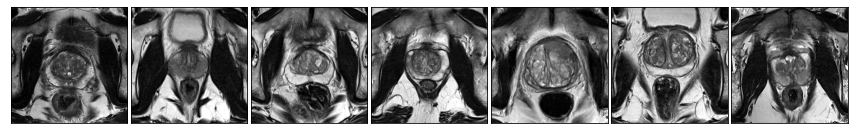

[1 2 1 0 0 1 0]
Image shape:  (18, 24, 256, 256, 3)
Time lapse 1.344318151473999


In [11]:
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

start_time = time()
for b in range(1):
    batch = next(dl)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)
print("Time lapse", time() - start_time)

## Crop 

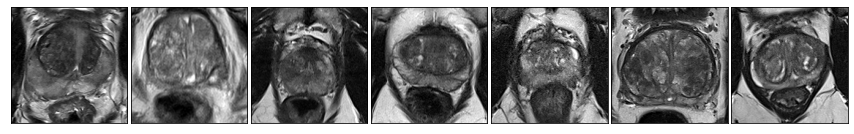

[2 1 0 0 0 1 2]
Image shape:  (18, 24, 160, 160, 3)
Time lapse 0.6342673301696777


In [12]:
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)

start_time = time()
for b in range(1):
    batch = next(dl)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)
print("Time lapse", time() - start_time)

----

# Data Augmentaion

## Elastic Transformation 

In [13]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform(
            patch_size,
            [i // 2 for i in patch_size],
            do_elastic_deform=True,
            alpha=(0., 300.),
            sigma=(20., 40.),
            do_rotation=True,
            angle_x=(-np.pi/30., np.pi/30),
            angle_y=(0.,0.),
            angle_z=(-np.pi/20., np.pi/20),
            do_scale=True,
            scale=(1/1.15, 1.15),
            random_crop=False,
            border_mode_data='constant',
            border_cval_data=0,
            order_data=3,
            p_el_per_sample=1.0, p_rot_per_sample=0., p_scale_per_sample=0.
        )
    )
    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

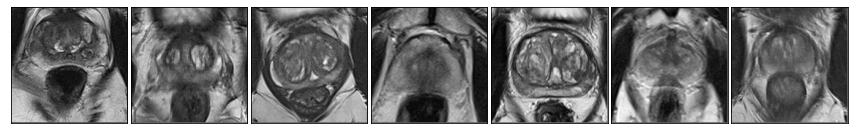

[2 0 2 1 2 1 2]
Image shape:  (18, 24, 160, 160, 3)


In [14]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Rotational Transformation 

In [54]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform(
            patch_size,
            [i // 2 for i in patch_size],
            do_elastic_deform=True,
            alpha=(0., 300.),
            sigma=(20., 40.),
            do_rotation=True,
            angle_x=(0., 0.),
            angle_y=(0., 0.),
            angle_z=(-np.pi/15., np.pi/15.),
#             angle_z=(0., 0.),
            do_scale=True,
            scale=(1/1.15, 1.15),
            random_crop=False,
            border_mode_data='constant',
            border_cval_data=0,
            order_data=3,
            p_el_per_sample=0., p_rot_per_sample=1.0, p_scale_per_sample=0.
        )
    )
    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

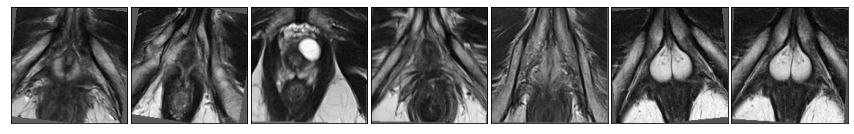

[0 1 0 0 2 2 2]
Image shape:  (12, 24, 160, 160, 3)


In [55]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 0,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Scale 

In [17]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform(
            patch_size,
            [i // 2 for i in patch_size],
            do_elastic_deform=True,
            alpha=(0., 300.),
            sigma=(20., 40.),
            do_rotation=True,
            angle_x=(-np.pi/30., np.pi/30),
            angle_y=(0.,0.),
            angle_z=(-np.pi/20., np.pi/20),
            do_scale=True,
            scale=(1/1.15, 1.15),
            random_crop=False,
            border_mode_data='constant',
            border_cval_data=0,
            order_data=3,
            p_el_per_sample=0., p_rot_per_sample=0., p_scale_per_sample=1.0
        )
    )
    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

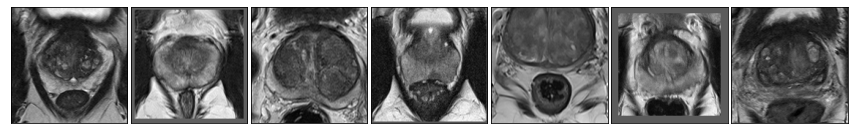

[1 2 2 2 1 0 2]
Image shape:  (18, 24, 160, 160, 3)


In [18]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Mirror Transformation

In [13]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
    tr_transforms.append(MirrorTransform(axes=(1,)))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms


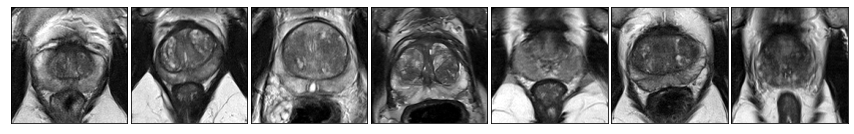

[0 2 2 1 2 0 0]
Image shape:  (12, 24, 160, 160, 3)


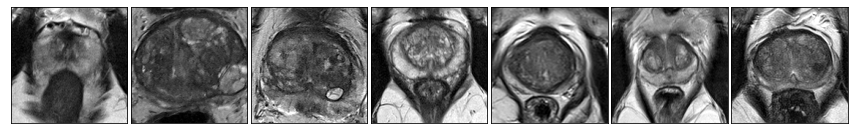

[0 1 0 0 1 2 1]
Image shape:  (12, 24, 160, 160, 3)


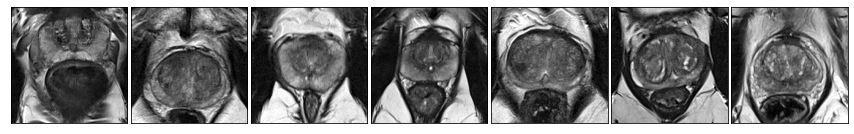

[1 0 2 2 1 2 0]
Image shape:  (12, 24, 160, 160, 3)


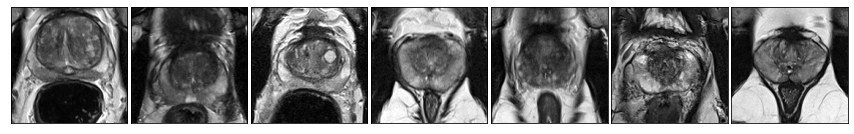

[2 1 1 2 0 0 1]
Image shape:  (12, 24, 160, 160, 3)


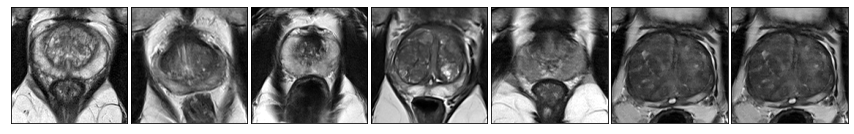

[0 2 0 1 2 1 1]
Image shape:  (12, 24, 160, 160, 3)


In [14]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(5):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Brightness Multiplicative Transform 

In [23]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
    tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=1.0))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=0.15))
#     # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=0.15))

#     # Gaussian Noise
#     tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))

#     # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
#     tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
#                                                p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

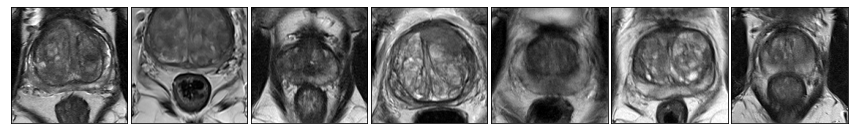

[2 1 0 0 0 2 2]
Image shape:  (18, 24, 160, 160, 3)


In [24]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Gamma Transformation, invert False

In [26]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
#     tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=1.0))
    # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=0.15))

#     # Gaussian Noise
#     tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))

#     # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
#     tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
#                                                p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

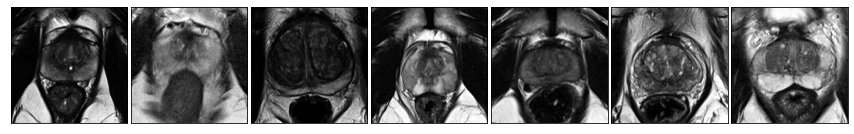

[2 0 1 2 2 0 0]
Image shape:  (18, 24, 160, 160, 3)


In [27]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Gamma Transformation, invert True

In [28]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
#     tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=1.0))
    # we can also invert the image, apply the transform and then invert back
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=1.0))

#     # Gaussian Noise
#     tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))

#     # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
#     tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
#                                                p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

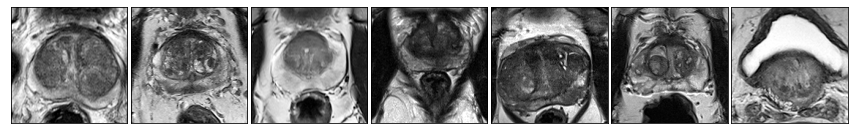

[2 0 1 2 0 2 1]
Image shape:  (18, 24, 160, 160, 3)


In [29]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Gaussian Noise

In [30]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
#     tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=1.0))
    # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=1.0))

#     # Gaussian Noise
    tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.5), p_per_sample=1.0))

#     # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
#     tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
#                                                p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

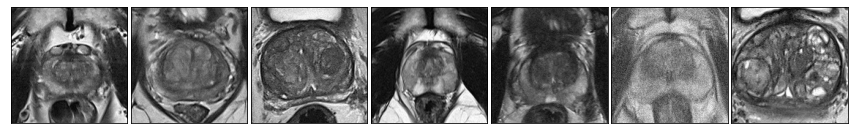

[0 1 1 2 1 1 2]
Image shape:  (12, 24, 160, 160, 3)


In [31]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Rician Noise 

In [44]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
#     tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=1.0))
    # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=1.0))

#     # Gaussian Noise
#     tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.1), p_per_sample=1.0))

#     # Rician Noise
    tr_transforms.append(RicianNoiseTransform(noise_variance=(0., 0.05), p_per_sample=1.0))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
#     tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
#                                                p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

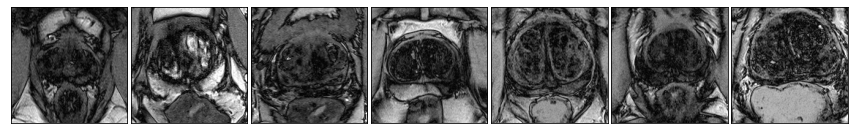

[0 2 2 0 1 2 1]
Image shape:  (12, 24, 160, 160, 3)


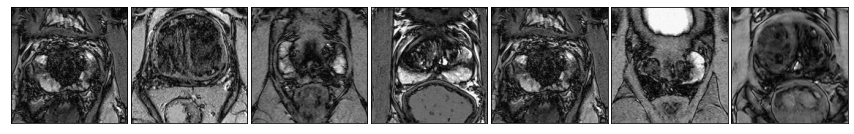

[0 1 2 1 0 2 1]
Image shape:  (12, 24, 160, 160, 3)


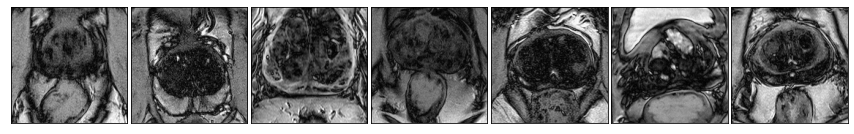

[2 1 1 2 1 1 2]
Image shape:  (12, 24, 160, 160, 3)


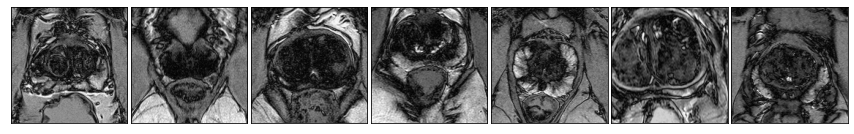

[2 2 1 2 0 0 1]
Image shape:  (12, 24, 160, 160, 3)


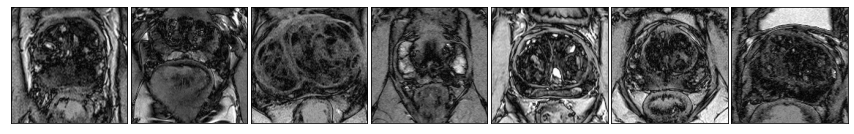

[0 1 1 2 2 0 1]
Image shape:  (12, 24, 160, 160, 3)


In [45]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(5):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Gaussian Blur

In [52]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
#     tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=1.0))
    # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=1.0))

#     # Gaussian Noise
#     tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.1), p_per_sample=1.0))

#     # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.1), p_per_sample=0.15))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
    tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 2.0), different_sigma_per_channel=True,
                                               p_per_channel=0.5, p_per_sample=1.0))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

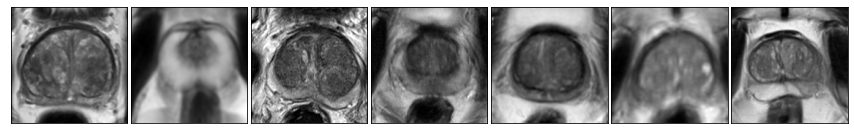

[1 1 2 0 2 2 0]
Image shape:  (12, 24, 160, 160, 3)


In [53]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Contrast Transformation 

In [65]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # now we mirror along all axes
#     tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
#     tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

#     # gamma transform. This is a nonlinear transformation of intensity values
#     # (https://en.wikipedia.org/wiki/Gamma_correction)
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=1.0))
    # we can also invert the image, apply the transform and then invert back
#     tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=1.0))

#     # Gaussian Noise
#     tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.1), p_per_sample=1.0))

#     # Rician Noise
#     tr_transforms.append(RicianNoiseTransform(noise_variance=(0, 0.1), p_per_sample=0.15))
#     # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
#     # thus make the model more robust to it
#     tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
#                                                p_per_channel=0.5, p_per_sample=1.0))
    tr_transforms.append(ContrastAugmentationTransform(contrast_range=(0.75, 1.25), p_per_sample=1.0))
    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

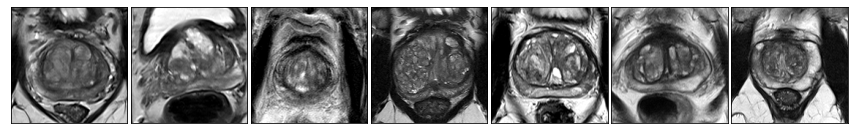

[1 1 1 2 2 2 0]
Image shape:  (18, 24, 160, 160, 3)


In [66]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(1):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

## Compose all

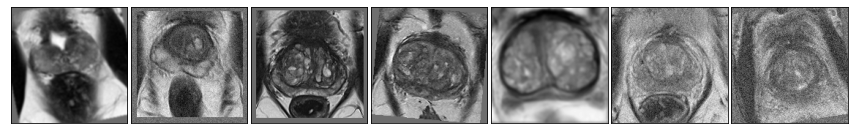

[2 0 2 0 1 0 1]
Image shape:  (12, 24, 160, 160, 3)


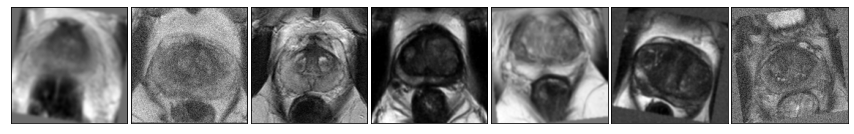

[2 0 2 2 1 0 0]
Image shape:  (12, 24, 160, 160, 3)


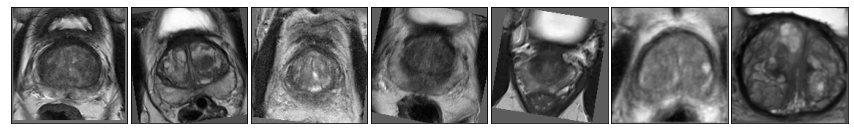

[0 2 1 0 2 2 1]
Image shape:  (12, 24, 160, 160, 3)


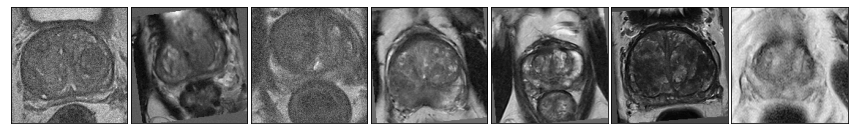

[1 1 1 0 0 1 2]
Image shape:  (12, 24, 160, 160, 3)


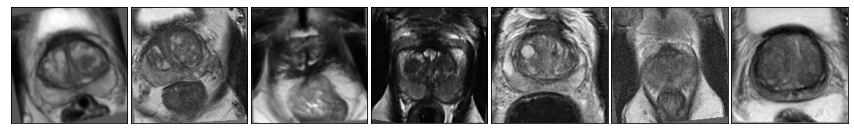

[2 0 0 0 1 2 2]
Image shape:  (12, 24, 160, 160, 3)


In [6]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

for b in range(5):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'][:7])
    print("Image shape: ",img.shape)

In [4]:
dl = BalancedDataLoader3D(data=ds_dict['train_ds'], sample_size=50, sample_per_class=sample_per_class, patch_size=(160, 160, 24), num_threads_in_multithreaded=1)
tr_transforms = get_train_transform(patch_size=(160, 160, 24))
tr_gen = SingleThreadedAugmenter(dl, tr_transforms)

total_batch = int(round(len(ds_dict['train_ds']['labels'])/(n_class*sample_per_class)))
print(total_batch)
start_time = time()
for b in range(total_batch):
    batch = next(tr_gen)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
#     img_list = [img[i, 12,...,0] for i in range(7)]
#     utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'])
    print("Image shape: ",img.shape)
print("Time lapse", time() - start_time)

22
[0 1 2 2 1 2 0 0 0 1 1 2]
Image shape:  (12, 24, 160, 160, 3)
[2 0 1 1 2 2 0 1 0 1 0 2]
Image shape:  (12, 24, 160, 160, 3)
[0 0 0 2 1 0 1 1 2 1 2 2]
Image shape:  (12, 24, 160, 160, 3)
[0 1 2 2 1 0 0 1 1 2 2 0]
Image shape:  (12, 24, 160, 160, 3)
[1 0 1 2 0 1 2 0 0 2 1 2]
Image shape:  (12, 24, 160, 160, 3)
[0 1 0 2 0 2 2 0 1 1 2 1]
Image shape:  (12, 24, 160, 160, 3)
[0 1 2 0 1 1 2 0 0 2 2 1]
Image shape:  (12, 24, 160, 160, 3)
[0 1 0 2 0 2 1 0 2 2 1 1]
Image shape:  (12, 24, 160, 160, 3)
[1 2 2 0 2 0 1 2 0 1 0 1]
Image shape:  (12, 24, 160, 160, 3)
[0 2 1 2 1 1 0 2 0 0 1 2]
Image shape:  (12, 24, 160, 160, 3)
[1 2 2 1 0 0 0 2 1 2 1 0]
Image shape:  (12, 24, 160, 160, 3)
[0 1 1 0 2 1 2 0 2 1 0 2]
Image shape:  (12, 24, 160, 160, 3)
[2 1 0 1 2 1 0 1 0 2 2 0]
Image shape:  (12, 24, 160, 160, 3)
[1 2 2 2 1 1 0 0 0 0 2 1]
Image shape:  (12, 24, 160, 160, 3)
[1 1 0 2 1 0 0 0 2 2 1 2]
Image shape:  (12, 24, 160, 160, 3)
[2 1 0 2 0 0 0 2 1 1 2 1]
Image shape:  (12, 24, 160, 160, 3)
[2 0 

# Validation Generator

In [5]:
class ValidationDataLoader3D(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded, crop=True, seed_for_shuffle=1234,
                 return_incomplete=True, shuffle=True, infinite=False):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the retured batch will have
        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        # original patch size with [slices, width, height]
        self.patch_size = patch_size
        self.num_modalities = 3
        self.indices = list(range(len(data['labels'])))
        self.crop = crop

    @staticmethod
    def load_patient(img_path):
        img = np.load(img_path, mmap_mode="r")
        return img

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        patients_for_batch = [self._data['npy_path'][i] for i in idx]
        patients_labels = [self._data['labels'][i] for i in idx]
        patient_id = [self._data['patient_id'][i] for i in idx]
        # initialize empty array for data and seg
        img = np.zeros((len(patients_for_batch), self.num_modalities, *self.patch_size), dtype=np.float32)

        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(patients_for_batch):
            patient_data = self.load_patient(j)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            # swap axes for crop function, (z, x, y, m) => (m, x, y, z)
            patient_data = np.swapaxes(patient_data,0,-1)
            if crop:
                patient_data = crop(patient_data[None], seg=None, crop_size=self.patch_size, crop_type="center")
            img[i] = patient_data[0]
        # img = np.swapaxes(img, 1, -1)
        patients_labels = np.array(patients_labels)
        return {'data': img, 'lbl': patients_labels, 'patient_id': patient_id}

## Validation Dataset with Shuffle 

Total len: 90
8


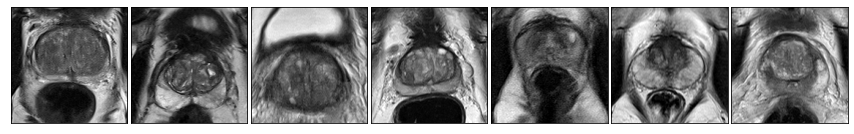

[2 0 1 0 1 2 0 1 2 0 0 0]
Image shape:  (12, 24, 160, 160, 3)


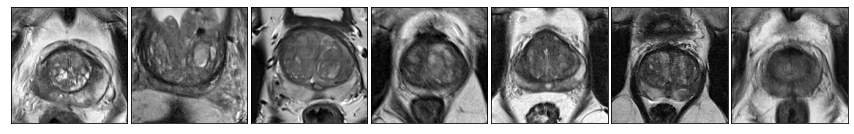

[0 0 1 1 2 2 2 0 2 1 0 1]
Image shape:  (12, 24, 160, 160, 3)


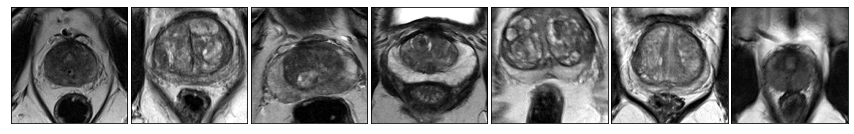

[0 1 0 1 0 2 2 0 1 1 1 0]
Image shape:  (12, 24, 160, 160, 3)


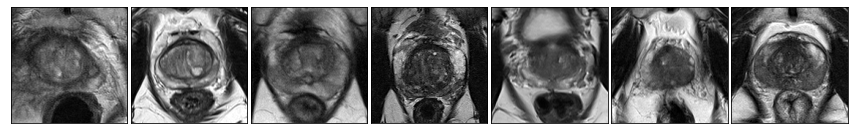

[1 2 2 2 1 0 2 1 0 0 2 2]
Image shape:  (12, 24, 160, 160, 3)


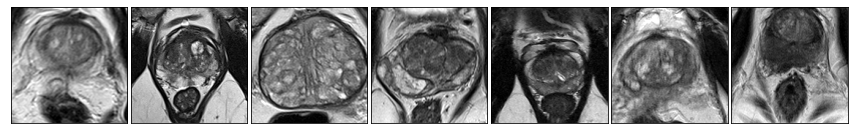

[1 0 1 1 1 2 0 1 1 2 1 1]
Image shape:  (12, 24, 160, 160, 3)
Time lapse 1.9189562797546387


In [8]:
val_dl = ValidationDataLoader3D(data=ds_dict['val_ds'], batch_size=12 , 
                                patch_size=(160, 160, 24), num_threads_in_multithreaded=1,
                                shuffle=True)
# val_gen = SingleThreadedAugmenter(val_dl, None)

total_batch = int(round(len(ds_dict['val_ds']['labels'])/(n_class*sample_per_class)))
print("Total len:", len(ds_dict['val_ds']['labels']))
print(total_batch)
label_batch = []
start_time = time()
for b in range(5):
    batch = next(val_dl)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
    img_list = [img[i, 12,...,0] for i in range(7)]
    utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'])
    label_batch.append(batch['lbl'].tolist())
    print("Image shape: ",img.shape)
print("Time lapse", time() - start_time)

In [6]:
label_batch_flatten = sum(label_batch, [])

In [7]:
values, counts = np.unique(np.array(label_batch_flatten), return_counts=True)
print(values)
print(counts)

[0 1 2]
[31 33 26]


## Validation Dataset without Shuffle

In [6]:
val_dl = ValidationDataLoader3D(data=ds_dict['val_ds'], batch_size=12 , 
                                patch_size=(160, 160, 24), num_threads_in_multithreaded=1,
                               shuffle=False)
# val_gen = SingleThreadedAugmenter(val_dl, None)

total_batch = int(round(len(ds_dict['val_ds']['labels'])/(n_class*sample_per_class)))
print("Total len:", len(ds_dict['val_ds']['labels']))
print(total_batch)
label_batch = []
start_time = time()
for b in range(total_batch):
    batch = next(val_dl)
    # swap axes for channel last
    img = np.swapaxes(batch["data"], 1,-1)
#     img_list = [img[i, 12,...,0] for i in range(6)]
#     utils_vis.grid_plot_nn(img_list, nrows=1, ncols=7, figsize=(15, 15))
    print(batch['lbl'])
    label_batch.append(batch['lbl'].tolist())
    print("Image shape: ",img.shape)
print("Time lapse", time() - start_time)

Total len: 90
8
[0 0 0 0 0 0 0 0 0 0 0 0]
Image shape:  (12, 24, 160, 160, 3)
[0 0 0 0 0 0 0 0 0 0 0 0]
Image shape:  (12, 24, 160, 160, 3)
[0 0 0 0 0 0 0 1 1 1 1 1]
Image shape:  (12, 24, 160, 160, 3)
[1 1 1 1 1 1 1 1 1 1 1 1]
Image shape:  (12, 24, 160, 160, 3)
[1 1 1 1 1 1 1 1 1 1 1 1]
Image shape:  (12, 24, 160, 160, 3)
[1 1 1 1 2 2 2 2 2 2 2 2]
Image shape:  (12, 24, 160, 160, 3)
[2 2 2 2 2 2 2 2 2 2 2 2]
Image shape:  (12, 24, 160, 160, 3)
[2 2 2 2 2 2]
Image shape:  (6, 24, 160, 160, 3)
Time lapse 1.46364164352417


In [7]:
label_batch_flatten = sum(label_batch, [])
values, counts = np.unique(np.array(label_batch_flatten), return_counts=True)
print(values)
print(counts)

[0 1 2]
[31 33 26]
